In [0]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [0]:
class ReviewsDataSet(torch.utils.data.Dataset):
    with open("100d_dictionary", "rb") as f:
        vocab = pickle.load(f)
    embedding_dim = 100

    def __init__(self, path_to_reviews, seq_length, features_first=False):
        self.seq_length = seq_length
        self.features_first = features_first

        self.positive_reviews_path = os.path.join(path_to_reviews, "pos")
        self.negative_reviews_path = os.path.join(path_to_reviews, "neg")
        
        positive_reviews = os.listdir(self.positive_reviews_path)
        negative_reviews = os.listdir(self.negative_reviews_path)
        
        self.reviews = positive_reviews + negative_reviews
        self.positive_number, self.negative_number = len(positive_reviews), len(negative_reviews)
        

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        positive = index < self.positive_number
        file_path = os.path.join(self.positive_reviews_path if positive else self.negative_reviews_path, self.reviews[index])
        
        with open(file_path, "r") as review_file:
            words = review_file.read().split()[:self.seq_length]
        
        x = [torch.zeros(ReviewsDataSet.embedding_dim) for i in range(self.seq_length - len(words))] +\
            [torch.from_numpy(ReviewsDataSet.vocab[word]) for word in words]
        
        x = torch.stack(x)
        return torch.transpose(x, 0, 1) if self.features_first else x, 1 if positive else 0

In [0]:
train_ds = ReviewsDataSet("cleaned_data/train", 250)
val_ds = ReviewsDataSet("cleaned_data/validation", 250)
test_ds = ReviewsDataSet("cleaned_data/test", 250)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=512, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=True)

In [8]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [0]:
def test_accuracy(model, dl, is_cuda):
    if is_cuda:
        model.cuda()

    model.eval()
    correct, total = 0, 0
    for X, y in dl:
        if is_cuda:
            X, y = X.cuda(), y.cuda()

        y_pred = torch.round(model(X).squeeze())
        mask = y_pred.eq(y.float())
        if is_cuda:
            mask = mask.cpu()
        correct += mask.sum().item()
        total += mask.shape[0]

    return correct / total

In [0]:
def train(model, train_dl, val_dl, lr, epochs, path, train_on_gpu, validation_period=3):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    if train_on_gpu:
        model.cuda()

    train_losses, val_accuracies, highest_accuracy = [], [], float("-inf")
    for i in range(epochs):
        model.train()

        batch_train_losses, batch_val_losses = [], []
        for X_train, y_train in train_dl:
            model.zero_grad()
            if train_on_gpu:
                X_train, y_train = X_train.cuda(), y_train.cuda()

            y_pred = model(X_train)
            loss = criterion(y_pred.squeeze(), y_train.float())
            batch_train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        
        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        summary = f"Epoch {i + 1}/{epochs}; train loss = {train_loss}; "
        if i % validation_period == 0:
          validation_accuracy = test_accuracy(model, val_dl, train_on_gpu)
          val_accuracies.append((i, validation_accuracy))
          summary += f"validation accuracy = {validation_accuracy}"

          if validation_accuracy > highest_accuracy:
              highest_accuracy = validation_accuracy
              torch.save(model.state_dict(), path)

        print(summary)

    plt.subplot(121)
    plt.plot(train_losses)
    plt.xlabel("epoch")
    plt.ylabel("train loss")

    plt.subplot(122)
    plt.scatter([e[0] for e in val_accuracies], [e[1] for e in val_accuracies])
    plt.xlabel("epoch")
    plt.ylabel("validation accuracy")
    model.load_state_dict(torch.load(path))

In [0]:
class SentimentRNN(torch.nn.Module):
    def __init__(self, rnn_class, embedding_dim, hidden_size, layers_number, drop_prob):
        super(SentimentRNN, self).__init__()
        
        self.rnn = rnn_class(embedding_dim, hidden_size, layers_number, batch_first=True, dropout=drop_prob)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = torch.nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [0]:
lstm = SentimentRNN(torch.nn.LSTM, ReviewsDataSet.embedding_dim, 120, 2, 0.3)

Epoch 1/19; train loss = 0.6783682205239121; validation accuracy = 0.5035449564937158
Epoch 2/19; train loss = 0.6369588058822009; 
Epoch 3/19; train loss = 0.5309625547759387; 
Epoch 4/19; train loss = 0.42562028765678406; validation accuracy = 0.8302449242668385
Epoch 5/19; train loss = 0.395197653040594; 
Epoch 6/19; train loss = 0.35290660359421555; 
Epoch 7/19; train loss = 0.33176328454698834; validation accuracy = 0.8611021592007735
Epoch 8/19; train loss = 0.30852581743074925; 
Epoch 9/19; train loss = 0.28826907033822974; 
Epoch 10/19; train loss = 0.27875643846940024; validation accuracy = 0.8610215920077344
Epoch 11/19; train loss = 0.26652608203644657; 
Epoch 12/19; train loss = 0.24645023291208307; 
Epoch 13/19; train loss = 0.22567516078754346; validation accuracy = 0.8606993232355785
Epoch 14/19; train loss = 0.23040466101802126; 
Epoch 15/19; train loss = 0.21975805139055057; 
Epoch 16/19; train loss = 0.20140210463076222; validation accuracy = 0.8670641314856591
Epoch 

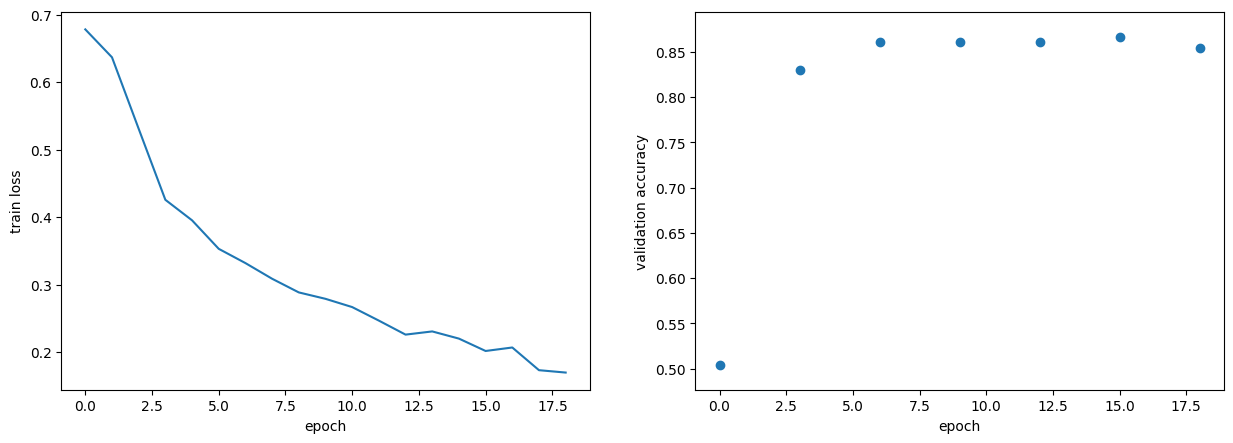

In [28]:
train(lstm, train_dl, val_dl, 0.02, 19, "best_lstm_model.pth", is_cuda)

In [29]:
test_accuracy(lstm, test_dl, is_cuda)

0.8665001611343861

In [0]:
gru = SentimentRNN(torch.nn.GRU, ReviewsDataSet.embedding_dim, 100, 2, 0.5)

Epoch 1/19; train loss = 0.5849051883026045; validation accuracy = 0.8152594263615855
Epoch 2/19; train loss = 0.3712217613142364; 
Epoch 3/19; train loss = 0.3272382057442957; 
Epoch 4/19; train loss = 0.2832398846441386; validation accuracy = 0.8693200128907509
Epoch 5/19; train loss = 0.24824631579068243; 
Epoch 6/19; train loss = 0.21388523675957505; 
Epoch 7/19; train loss = 0.17389564155315868; validation accuracy = 0.8659361907831131
Epoch 8/19; train loss = 0.14470623737695265; 
Epoch 9/19; train loss = 0.2632756922013906; 
Epoch 10/19; train loss = 0.18958417402238262; validation accuracy = 0.8697228488559459
Epoch 11/19; train loss = 0.14788213144151532; 
Epoch 12/19; train loss = 0.13019332989138; 
Epoch 13/19; train loss = 0.11679847523265956; validation accuracy = 0.8562681276184337
Epoch 14/19; train loss = 0.10826563576654512; 
Epoch 15/19; train loss = 0.10399685108235904; 
Epoch 16/19; train loss = 0.09509773962959951; validation accuracy = 0.8554624556880438
Epoch 17/

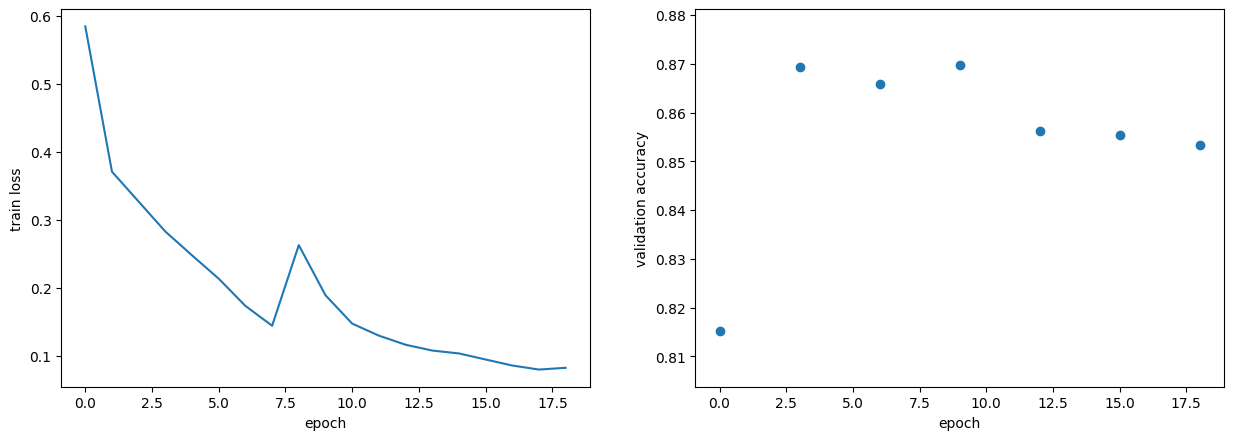

In [31]:
train(gru, train_dl, val_dl, 0.01, 19, "best_gru_model.pth", is_cuda)

In [33]:
test_accuracy(gru, test_dl, is_cuda)

0.8644859813084113

In [0]:
class Attention(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(Attention, self).__init__()

        self.lstm = torch.nn.LSTM(embedding_dim, 256, batch_first=True, bidirectional=True)
        self.attention = torch.nn.Linear(256 * 2, 1)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(256 * 2, 100)
        self.fc2 = torch.nn.Linear(100, 1)

    def forward(self, x):
        batch_size, seq_length = x.shape[0], x.shape[1]

        lstm_embeddings, _ = self.lstm(x)
        attention_coefficients = self.attention(lstm_embeddings)
        attention_coefficients = attention_coefficients.view((batch_size, seq_length))
        attention_coefficients = torch.nn.functional.softmax(attention_coefficients, dim=1)
        attention_coefficients = attention_coefficients.view((batch_size, seq_length, 1))

        attention_embeddings = (lstm_embeddings * attention_coefficients).sum(dim=1)

        x = torch.relu(self.fc1(attention_embeddings))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x))

In [0]:
attention = Attention(ReviewsDataSet.embedding_dim)

Epoch 1/19; train loss = 0.7810470741622302; validation accuracy = 0.5800837898807606
Epoch 2/19; train loss = 0.5275293387928788; 
Epoch 3/19; train loss = 0.38350312807122056; 
Epoch 4/19; train loss = 0.3241643254854241; validation accuracy = 0.8589268449887206
Epoch 5/19; train loss = 0.2891402262814191; 
Epoch 6/19; train loss = 0.25209543504277054; 
Epoch 7/19; train loss = 0.22921267486348443; validation accuracy = 0.8591685465678376
Epoch 8/19; train loss = 0.20133891245540309; 
Epoch 9/19; train loss = 0.17934610360130973; 
Epoch 10/19; train loss = 0.1713398780141558; validation accuracy = 0.8631969062197873
Epoch 11/19; train loss = 0.16252689139575374; 
Epoch 12/19; train loss = 0.16846117833439184; 
Epoch 13/19; train loss = 0.15650642389545635; validation accuracy = 0.8599742184982275
Epoch 14/19; train loss = 0.16713891269601122; 
Epoch 15/19; train loss = 0.178568568612848; 
Epoch 16/19; train loss = 0.15059815772942134; validation accuracy = 0.8593296809539156
Epoch 17

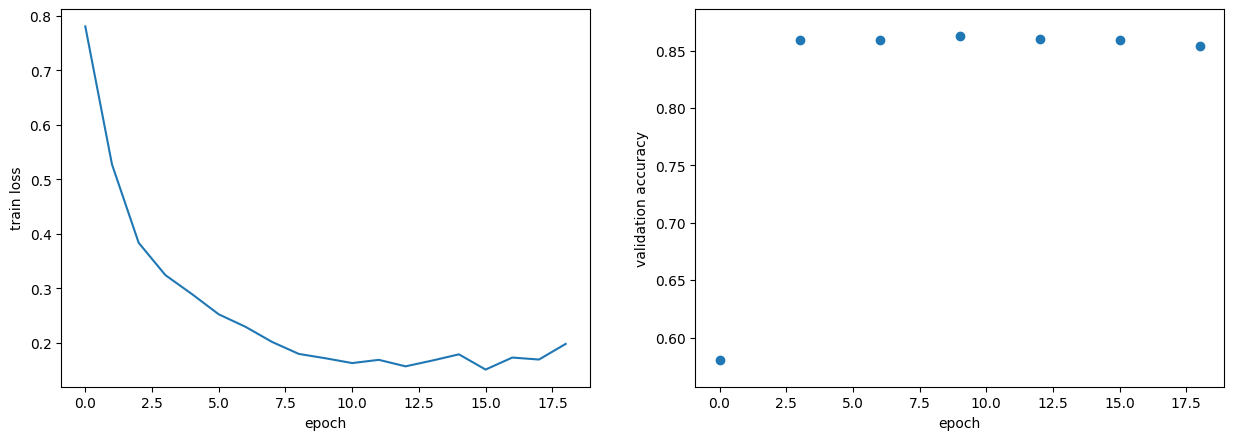

In [36]:
train(attention, train_dl, val_dl, 0.02, 19, "best_attention_model.pth", is_cuda)

In [37]:
test_accuracy(attention, test_dl, is_cuda)

0.8636803093780213

In [0]:
class SentimentCNN(torch.nn.Module):
    def __init__(self, embedding_dim):
        super(SentimentCNN, self).__init__()
        
        self.conv1 = torch.nn.Conv1d(embedding_dim, 128, 5, 2)
        self.conv2 = torch.nn.Conv1d(128, 256, 5, 2)
        self.conv3 = torch.nn.Conv1d(256, 512, 3, 2)

        self.max_pool = torch.nn.MaxPool1d(2)
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(512 * 6, 100)
        self.fc2 = torch.nn.Linear(100, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)
        x = torch.relu(self.conv2(x))
        x = self.max_pool(x)
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [0]:
train_ds = ReviewsDataSet("cleaned_data/train", 250, features_first=True)
val_ds = ReviewsDataSet("cleaned_data/validation", 250, features_first=True)
test_ds = ReviewsDataSet("cleaned_data/test", 250, features_first=True)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=512, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=True)

In [0]:
cnn = SentimentCNN(ReviewsDataSet.embedding_dim)

Epoch 1/19; train loss = 0.931628632302187; validation accuracy = 0.6873992910087012
Epoch 2/19; train loss = 0.5727122991668935; 
Epoch 3/19; train loss = 0.4788615758321723; 
Epoch 4/19; train loss = 0.42528918385505676; validation accuracy = 0.7772317112471802
Epoch 5/19; train loss = 0.3870753493844246; 
Epoch 6/19; train loss = 0.34519006524767193; 
Epoch 7/19; train loss = 0.3157685496369187; validation accuracy = 0.7866580728327425
Epoch 8/19; train loss = 0.2761387320197358; 
Epoch 9/19; train loss = 0.24835784064263713; 
Epoch 10/19; train loss = 0.21731336141119198; validation accuracy = 0.7566870770222366
Epoch 11/19; train loss = 0.20026164152184311; 
Epoch 12/19; train loss = 0.1948722340926832; 
Epoch 13/19; train loss = 0.1751999260515583; validation accuracy = 0.7679664840476957
Epoch 14/19; train loss = 0.15821770456980686; 
Epoch 15/19; train loss = 0.13412379944811062; 
Epoch 16/19; train loss = 0.12152759472326356; validation accuracy = 0.7580567193038995
Epoch 17/1

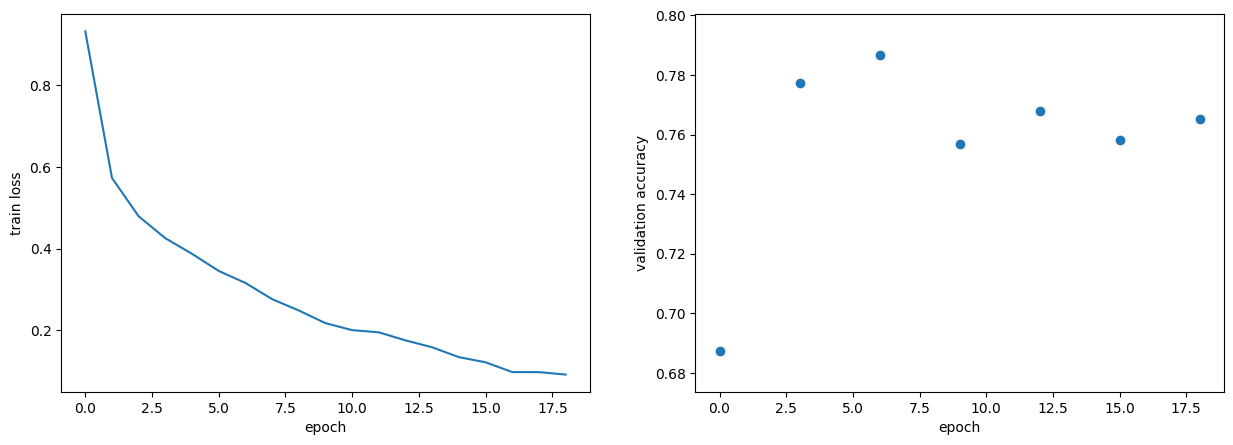

In [16]:
train(cnn, train_dl, val_dl, 0.01, 19, "best_cnn_model.pth", is_cuda)

In [17]:
test_accuracy(cnn, test_dl, is_cuda)

0.7882694166935224